## Convolutional Neural Network (CNN)

In [22]:
import pandas as pd
import numpy as np
from surprise import KNNBasic, Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import keras
from keras import layers

### Load Data

In [2]:
data = pd.read_csv("data/Tempat-Wisata-Toba-Preprocessing.csv")

In [3]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'address', 'PlaceID',
       'Nama_tempat_wisata', 'Category', 'ReviewerId', 'Rating', 'Reviews'],
      dtype='object')

In [4]:
data = data.rename(columns={'ReviewerId': 'user_id', 'PlaceID': 'item_id', 'Rating': 'rating'})
data['rating'] = data['rating'].astype(float)
data.dropna(inplace=True)
data.head()

,Unnamed: 0.1,Unnamed: 0,address,item_id,Nama_tempat_wisata,Category,user_id,rating,Reviews
1,1,1,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.119090e+20,5.0,bagus
3,3,3,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.130720e+20,5.0,sangat menyenagkan
4,4,4,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.061730e+20,5.0,bebas foto dimana aja cuma 2k
6,6,6,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.142390e+20,5.0,amazing pengen kesini lagi
8,8,8,"Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...",0,PASIR PUTIH LUMBAN BULBUL,Wisata Bahari,1.047430e+20,3.0,jalan menuju lokasi perlu diperhatikan oleh pe...


In [5]:
col_to_drop = ['Unnamed: 0.1', 'Unnamed: 0', 'address', 'Category', 'Reviews']
data = data.drop(columns=col_to_drop)
data.head()

,item_id,Nama_tempat_wisata,user_id,rating
1,0,PASIR PUTIH LUMBAN BULBUL,1.119090e+20,5.0
3,0,PASIR PUTIH LUMBAN BULBUL,1.130720e+20,5.0
4,0,PASIR PUTIH LUMBAN BULBUL,1.061730e+20,5.0
6,0,PASIR PUTIH LUMBAN BULBUL,1.142390e+20,5.0
8,0,PASIR PUTIH LUMBAN BULBUL,1.047430e+20,3.0


In [6]:
data.shape

(22166, 4)

In [7]:
# Define Reader object
reader = Reader(rating_scale=(data['rating'].min(), data['rating'].max()))
dataset = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader)

### Split Data

In [8]:
from sklearn.model_selection import train_test_split

# Membagi data menjadi train (70%) dan sisanya (30%)
train_data, temp_data = train_test_split(data, test_size=0.30, random_state=42)

# Membagi temp_data menjadi validation (15% dari total data) dan test (15% dari total data)
val_data, test_data = train_test_split(temp_data, test_size=0.50, random_state=42)

# Menampilkan hasil pembagian data
print(f"Train data shape: {train_data.shape} ({len(train_data) / len(data):.2%} dari total data)")
print(f"Validation data shape: {val_data.shape} ({len(val_data) / len(data):.2%} dari total data)")
print(f"Test data shape: {test_data.shape} ({len(test_data) / len(data):.2%} dari total data)")


Train data shape: (15516, 4) (70.00% dari total data)
Validation data shape: (3325, 4) (15.00% dari total data)
Test data shape: (3325, 4) (15.00% dari total data)


## Create User-Item Matrix

In [9]:
# Create user-item matrix
def create_user_item_matrix(data, user_col='user_id', item_col='item_id', rating_col='rating'):
    data = data.groupby([user_col, item_col])[rating_col].mean().reset_index()
    return data.pivot(index=user_col, columns=item_col, values=rating_col).fillna(0)

# Generate matrices for each split
train_matrix = create_user_item_matrix(train_data)
val_matrix = create_user_item_matrix(val_data).reindex(columns=train_matrix.columns, fill_value=0)
test_matrix = create_user_item_matrix(test_data).reindex(columns=train_matrix.columns, fill_value=0)

# Print the matrices
print("Train Matrix:")
print(train_matrix)
print("\nValidation Matrix:")
print(val_matrix)
print("\nTest Matrix:")
print(test_matrix)

Train Matrix:
item_id       0    1    2    3    4    5    6    8    9    10   ...  92   93   \
user_id                                                         ...             
1.000030e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1.000040e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1.000090e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1.000100e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1.000120e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1.184390e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  5.0  0.0   
1.184410e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1.184430e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  5.0   
1.184440e+20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1.184460e+20  

In [10]:
# Filter hanya user dengan minimal 10 interaksi
user_counts = data['user_id'].value_counts()
active_users = user_counts[user_counts >= 10].index
filtered_data = data[data['user_id'].isin(active_users)]

dataset = Dataset.load_from_df(filtered_data[['user_id', 'Nama_tempat_wisata', 'rating']], reader)

### User-Profile & Item-Profile

In [11]:
import pandas as pd
from sklearn.decomposition import NMF


# Membuat NMF Model
def create_user_item_profiles(train_matrix, n_components=5):
    """
    Membuat user profile (W) dan item profile (H) menggunakan NMF.
    """
    model = NMF(n_components=n_components, init='random', random_state=42, max_iter=500)
    W = model.fit_transform(train_matrix)
    H = model.components_
    return W, H

# Menentukan jumlah komponen
n_components = 5

# Membuat user profile dan item profile
user_profile, item_profile = create_user_item_profiles(train_matrix, n_components=n_components)

# Menyimpan user profile ke DataFrame
user_profile_df = pd.DataFrame(user_profile,
                               index=train_matrix.index,
                               columns=[f'feature_{i+1}' for i in range(user_profile.shape[1])])

# Menyimpan item profile ke DataFrame
item_profile_df = pd.DataFrame(item_profile.T,
                               index=train_matrix.columns,
                               columns=[f'feature_{i+1}' for i in range(item_profile.shape[0])])

# Menampilkan hasil
print("User Profile:")
print(user_profile_df)

print("\nItem Profile:")
print(item_profile_df)

# Simpan hasil ke CSV
user_profile_df.to_csv("user_profile.csv", index=True)
item_profile_df.to_csv("item_profile.csv", index=True)


User Profile:
              feature_1  feature_2  feature_3  feature_4  feature_5
user_id                                                            
1.000030e+20   0.000000   0.036775   0.026203   0.031098   0.317672
1.000040e+20   0.000000   0.000000   0.000000   1.770536   0.000000
1.000090e+20   0.000000   0.000000   0.000000   0.000000   0.885755
1.000100e+20   0.000000   0.000000   1.209843   0.000000   0.000000
1.000120e+20   0.000000   0.007574   0.000000   0.013873   0.315452
...                 ...        ...        ...        ...        ...
1.184390e+20   0.007485   0.018673   0.023109   0.000000   0.128271
1.184410e+20   0.048425   0.000000   0.000000   0.000000   0.354191
1.184430e+20   1.918179   0.006708   0.032333   0.000000   0.198410
1.184440e+20   0.000000   0.000000   1.206284   2.215178   0.017028
1.184460e+20   0.078109   0.053537   0.029770   0.090480   0.234539

[8888 rows x 5 columns]

Item Profile:
         feature_1  feature_2  feature_3  feature_4      featu

In [12]:
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle
import numpy as np

# Convert train_matrix to pairs of (user, item, rating)
def matrix_to_triplets(matrix):
    triplets = []
    for i in range(matrix.shape[0]):  # Iterate over users
        for j in range(matrix.shape[1]):  # Iterate over items
            if matrix[i, j] > 0:  # Include only non-zero ratings
                triplets.append((i, j, matrix[i, j]))
    return np.array(triplets)

# Convert train, val, and test matrices to triplets
train_triplets = matrix_to_triplets(train_matrix.values)
val_triplets = matrix_to_triplets(val_matrix.values)
test_triplets = matrix_to_triplets(test_matrix.values)

In [13]:
# Pastikan tipe data user dan item sebagai integer
def prepare_cnn_input(triplets, n_users, n_items):
    user_input = triplets[:, 0].astype(int)  # Konversi ke integer
    item_input = triplets[:, 1].astype(int)  # Konversi ke integer
    ratings = triplets[:, 2]
    
    # One-hot encode users dan items
    user_features = np.eye(n_users)[user_input]
    item_features = np.eye(n_items)[item_input]
    
    # Gabungkan fitur user dan item menjadi satu input
    input_features = np.hstack([user_features, item_features])
    return input_features, ratings

# Tetap gunakan blok utama dari kode sebelumnya
n_users, n_items = train_matrix.shape
train_X, train_y = prepare_cnn_input(train_triplets, n_users, n_items)
val_X, val_y = prepare_cnn_input(val_triplets, n_users, n_items)
test_X, test_y = prepare_cnn_input(test_triplets, n_users, n_items)

In [14]:
# pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import keras_tuner as kt

# Definisikan fungsi untuk membuat model dengan hyperparameter
def build_model(hp):
    model = models.Sequential([
        layers.Dense(hp.Int('units_1', min_value=64, max_value=256, step=64),
                     activation='relu', input_shape=input_shape),
        layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),
        layers.Dense(hp.Int('units_2', min_value=32, max_value=128, step=32),
                     activation='relu'),
        layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)),
        layers.Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='mse',
        metrics=['mae']
    )
    return model

In [19]:
def build_model(hp, input_shape):
    model = keras.Sequential([
        keras.layers.Dense(
            hp.Int('units_1', min_value=64, max_value=256, step=64),
            activation='relu',
            input_shape=input_shape
        ),
        keras.layers.Dropout(
            hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)
        ),
        keras.layers.Dense(
            hp.Int('units_2', min_value=32, max_value=128, step=32),
            activation='relu'
        ),
        keras.layers.Dropout(
            hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)
        ),
        keras.layers.Dense(1, activation='linear')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        ),
        loss='mse',
        metrics=['mae']
    )
    return model

input_shape = (train_X.shape[1],)

In [20]:
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, input_shape),
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='recommendation_cnn'
)

Reloading Tuner from hyperparameter_tuning\recommendation_cnn\tuner0.json


In [23]:
tuner.search(train_X, train_y, validation_data=(val_X, val_y), epochs=10, batch_size=32)

Trial 10 Complete [00h 01m 17s]
val_loss: 0.7166847586631775

Best val_loss So Far: 0.7166847586631775
Total elapsed time: 00h 25m 53s


In [24]:
# Dapatkan model dengan hyperparameter terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Hyperparameter terbaik:
- Units Layer 1: {best_hps.get('units_1')}
- Dropout Layer 1: {best_hps.get('dropout_1')}
- Units Layer 2: {best_hps.get('units_2')}
- Dropout Layer 2: {best_hps.get('dropout_2')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

# Latih model dengan hyperparameter terbaik
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=20, batch_size=32, verbose=1
)


Hyperparameter terbaik:
- Units Layer 1: 128
- Dropout Layer 1: 0.30000000000000004
- Units Layer 2: 96
- Dropout Layer 2: 0.30000000000000004
- Learning Rate: 0.0001

Epoch 1/20
480/480 [==============================] - 11s 18ms/step - loss: 10.2529 - mae: 2.7824 - val_loss: 0.8223 - val_mae: 0.7183
Epoch 2/20
480/480 [==============================] - 8s 16ms/step - loss: 1.0157 - mae: 0.7699 - val_loss: 0.7270 - val_mae: 0.6707
Epoch 3/20
480/480 [==============================] - 8s 16ms/step - loss: 0.8955 - mae: 0.7145 - val_loss: 0.7262 - val_mae: 0.6707
Epoch 4/20
480/480 [==============================] - 7s 16ms/step - loss: 0.8334 - mae: 0.6860 - val_loss: 0.7339 - val_mae: 0.6505
Epoch 5/20
480/480 [==============================] - 8s 16ms/step - loss: 0.7675 - mae: 0.6574 - val_loss: 0.7558 - val_mae: 0.6449
Epoch 6/20
480/480 [==============================] - 7s 15ms/step - loss: 0.7322 - mae: 0.6389 - val_loss: 0.7926 - val_mae: 0.6761
Epoch 7/20
480/480 [===========

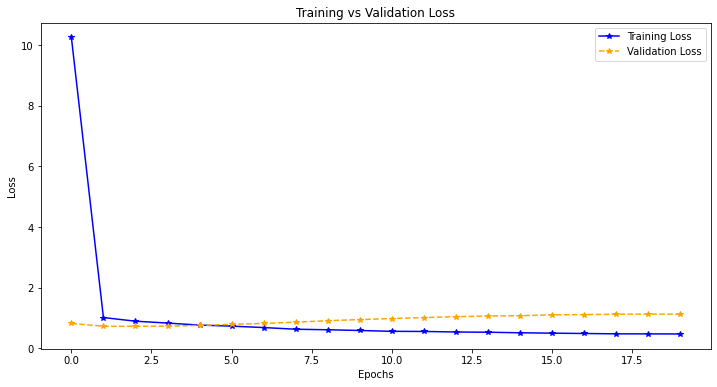

In [64]:
import matplotlib.pyplot as plt

# Set ukuran gambar menjadi lebih lebar
plt.figure(figsize=(12, 6))

plt.plot(
    history.history['loss'], 
    label='Training Loss', 
    linestyle='-', 
    marker='*', 
    color='blue'
)

# Plot validation loss dengan pola garis putus-putus dan bintang
plt.plot(
    history.history['val_loss'], 
    label='Validation Loss', 
    linestyle='--', 
    marker='*', 
    color='orange'
)

# Label untuk sumbu x dan y
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Menambahkan judul dan legenda
plt.title('Training vs Validation Loss')
plt.legend()

# Menampilkan grafik
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Evaluasi RMSE dan MAE
predicted_ratings = model.predict(test_X).flatten()

# Jika target test_y dinormalisasi, denormalisasi terlebih dahulu (opsional)
# test_y = scaler.inverse_transform(test_y)  # Uncomment jika diperlukan
# predicted_ratings = scaler.inverse_transform(predicted_ratings.reshape(-1, 1)).flatten()  # Uncomment jika diperlukan

# Hitung RMSE dan MAE
rmse = np.sqrt(mean_squared_error(test_y, predicted_ratings))
mae = mean_absolute_error(test_y, predicted_ratings)

print("Evaluasi Model:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

104/104 [==============================] - 1s 6ms/step
Evaluasi Model:
RMSE: 1.0672
MAE: 0.7594


In [35]:
# Precision, Recall, MAP@K
def precision_recall_at_k(predictions, true_ratings, k=5):
    sorted_indices = np.argsort(predictions)[::-1]  # Sort predictions in descending order
    top_k_indices = sorted_indices[:k]
    relevant = np.isin(top_k_indices, np.where(true_ratings > 0)[0])
    precision = np.sum(relevant) / k
    recall = np.sum(relevant) / np.sum(true_ratings > 0)
    return precision, recall

def mean_average_precision_at_k(predictions, true_ratings, k=5):
    sorted_indices = np.argsort(predictions)[::-1]  # Sort predictions in descending order
    top_k_indices = sorted_indices[:k]
    ap = 0
    num_relevant = 0
    for i, idx in enumerate(top_k_indices):
        if true_ratings[idx] > 0:
            num_relevant += 1
            ap += num_relevant / (i + 1)
    return ap / min(k, np.sum(true_ratings > 0))

precision_5, recall_5 = precision_recall_at_k(predicted_ratings, test_y, k=5)
precision_10, recall_10 = precision_recall_at_k(predicted_ratings, test_y, k=10)
map_5 = mean_average_precision_at_k(predicted_ratings, test_y, k=5)
map_10 = mean_average_precision_at_k(predicted_ratings, test_y, k=10)

print(f"Precision@5: {precision_5:.4f}, Recall@5: {recall_5:.4f}, MAP@5: {map_5:.4f}")
print(f"Precision@10: {precision_10:.4f}, Recall@10: {recall_10:.4f}, MAP@10: {map_10:.4f}")

Precision@5: 1.0000, Recall@5: 0.0015, MAP@5: 1.0000
Precision@10: 1.0000, Recall@10: 0.0030, MAP@10: 1.0000


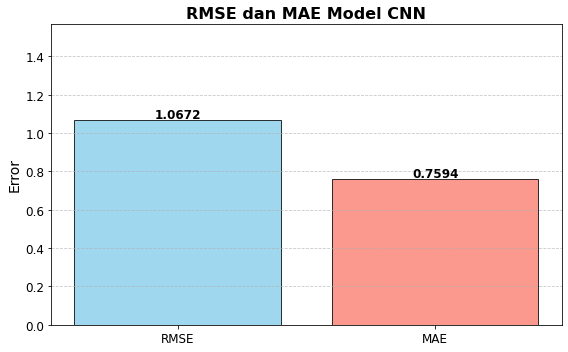

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Simpan nilai RMSE dan MAE yang sudah dihitung
metrics = {'RMSE': rmse, 'MAE': mae}

# Visualisasi menggunakan diagram batang
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'salmon'], alpha=0.8, edgecolor='black')

# Tambahkan nilai di atas batang
for i, (metric, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.01, f'{value:.4f}', ha='center', fontsize=12, fontweight='bold')

# Tambahkan detail pada plot
plt.title('RMSE dan MAE Model CNN', fontsize=16, fontweight='bold')
plt.ylabel('Error', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max(metrics.values()) + 0.5)

# Tampilkan diagram batang
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


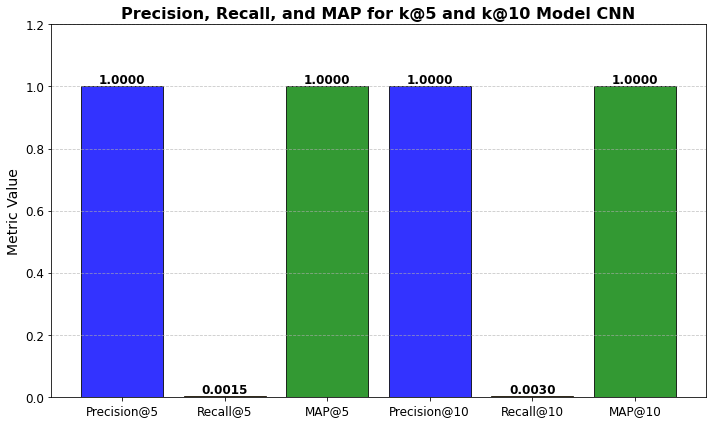

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Simpan nilai Precision, Recall, dan MAP untuk k@5 dan k@10
metrics = {
    'Precision@5': 1.0000,
    'Recall@5': 0.0015,
    'MAP@5': 1.0000,
    'Precision@10': 1.0000,
    'Recall@10': 0.0030,
    'MAP@10': 1.0000
}

# Visualisasi menggunakan diagram batang
plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green', 'blue', 'orange', 'green'], alpha=0.8, edgecolor='black')

# Tambahkan nilai di atas batang
for i, (metric, value) in enumerate(metrics.items()):
    plt.text(i, value + 0.01, f'{value:.4f}', ha='center', fontsize=12, fontweight='bold')

# Tambahkan detail pada plot
plt.title('Precision, Recall, and MAP for k@5 and k@10 Model CNN', fontsize=16, fontweight='bold')
plt.ylabel('Metric Value', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max(metrics.values()) + 0.2)

# Tampilkan diagram batang
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [62]:
# import pandas as pd

# def get_top_n_recommendations_table(predictions, user_id, n=5):
#     """
#     Mengembalikan top-N rekomendasi dalam bentuk tabel.
    
#     Parameters:
#     - predictions: List prediksi dari Surprise
#     - user_id: ID user yang ingin ditampilkan rekomendasinya
#     - n: Jumlah rekomendasi yang diinginkan (default: 5)
    
#     Returns:
#     - DataFrame berisi item_id, nama tempat wisata, dan prediksi rating
#     """
#     # Filter prediksi untuk user tertentu
#     user_predictions = [pred for pred in predictions if pred.uid == user_id]
    
#     # Urutkan berdasarkan rating prediksi (descending)
#     user_predictions.sort(key=lambda x: x.est, reverse=True)
    
#     # Ambil top-N rekomendasi
#     top_n = user_predictions[:n]
    
#     # Format data untuk DataFrame
#     top_n_data = []
#     for pred in top_n:
#         place_name = data[data['item_id'] == pred.iid]['Nama_tempat_wisata'].iloc[0]
#         top_n_data.append({'Place ID': pred.iid, 'Nama Tempat Wisata': place_name, 'Predicted Rating': pred.est})
    
#     # Konversi ke DataFrame
#     return pd.DataFrame(top_n_data)

# # Pilih user_id untuk melihat rekomendasi
# user_id = '1.08733e+20'  # Ganti dengan ID user yang diinginkan

# # Dapatkan daftar semua item di dataset
# all_items = set(data['item_id'].unique())

# # Cari item yang belum di-rating oleh user
# rated_items = set(data[data['user_id'] == user_id]['item_id'])
# unrated_items = all_items - rated_items

# # Buat testset untuk user dengan semua item yang belum di-rating
# user_testset = [(user_id, item_id, 0) for item_id in unrated_items]

# # Prediksi untuk semua item di testset
# user_predictions = model.test(user_testset)

# # Dapatkan top 5 rekomendasi dalam bentuk tabel
# top_5_recommendations_table = get_top_n_recommendations_table(user_predictions, user_id, n=5)

# # Tampilkan tabel
# print("Top 5 rekomendasi untuk User {}:".format(user_id))
# print(top_5_recommendations_table)